In [1]:
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    directory="/kaggle/input/glasses-classification-dataset/train",
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    batch_size=16,
    image_size=(224, 224),
    shuffle=True
)

Found 104 files belonging to 2 classes.


In [2]:
class_names = train_dataset.class_names
print(class_names)

['glasses', 'noglasses']


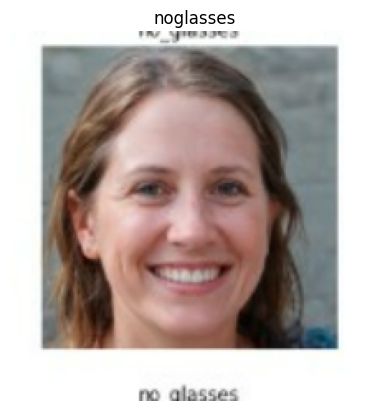

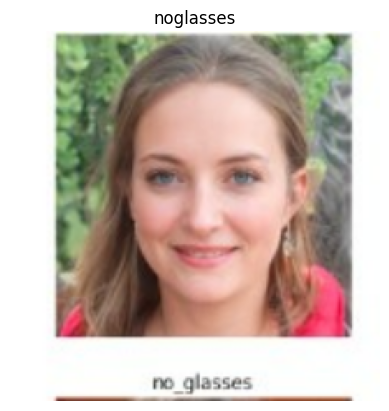

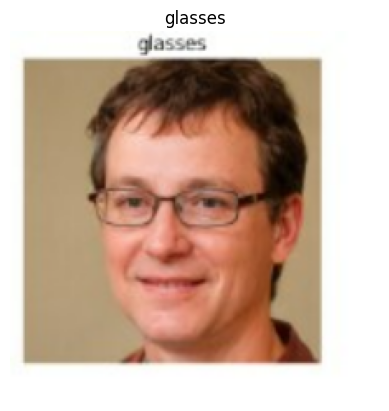

In [3]:
import matplotlib.pyplot as plt
import numpy as np

for images, labels in train_dataset.take(1):
    for idx in range(3):
        image = images[idx].numpy().astype(np.uint8)
        label = labels [idx].numpy()
    
        label = int(label[0])
        class_name = class_names[label]
        
        plt.imshow(image)
        plt.axis("off")
        plt.title(class_name)
        plt.show()    
    break

In [4]:
val_dataset = image_dataset_from_directory(
    directory="/kaggle/input/glasses-classification-dataset/validate",
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    batch_size=16,
    image_size=(224, 224)
)

Found 40 files belonging to 2 classes.


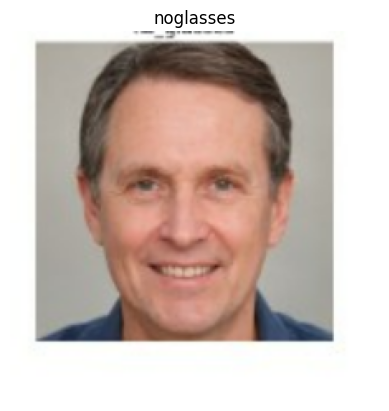

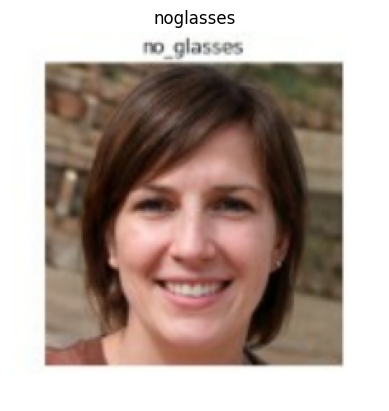

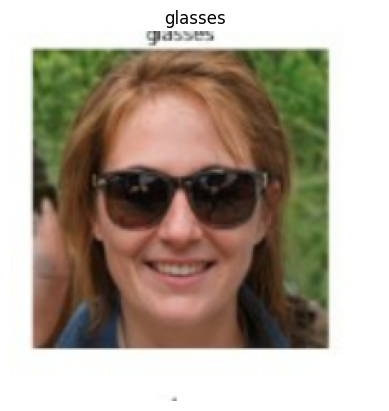

In [5]:
for images, labels in val_dataset.take(1):
    for idx in range(3):
        image = images[idx].numpy().astype(np.uint8)
        label = labels [idx].numpy()
    
        label = int(label[0])
        class_name = class_names[label]
        
        plt.imshow(image)
        plt.axis("off")
        plt.title(class_name)
        plt.show()    
    break

## Probar capas de Data Augmentation

In [6]:
#Función para visualizar los datos aumentados
import matplotlib.pyplot as plt

def plot_images(dataset, data_augmentation_pipeline, rows = 3, cols= 3):
    for image_batch, _ in dataset.take(1):
        plt.figure(figsize=(15, 8))

        for i in range(rows * cols):
            augmented_images = data_augmentation_pipeline(image_batch)

            # Display just the first augmented image from the batch of augmented images.
            plt.subplot(rows, cols, i + 1)
            plt.imshow(augmented_images[i].numpy().astype("uint8"))
            plt.axis("off")
    plt.show()

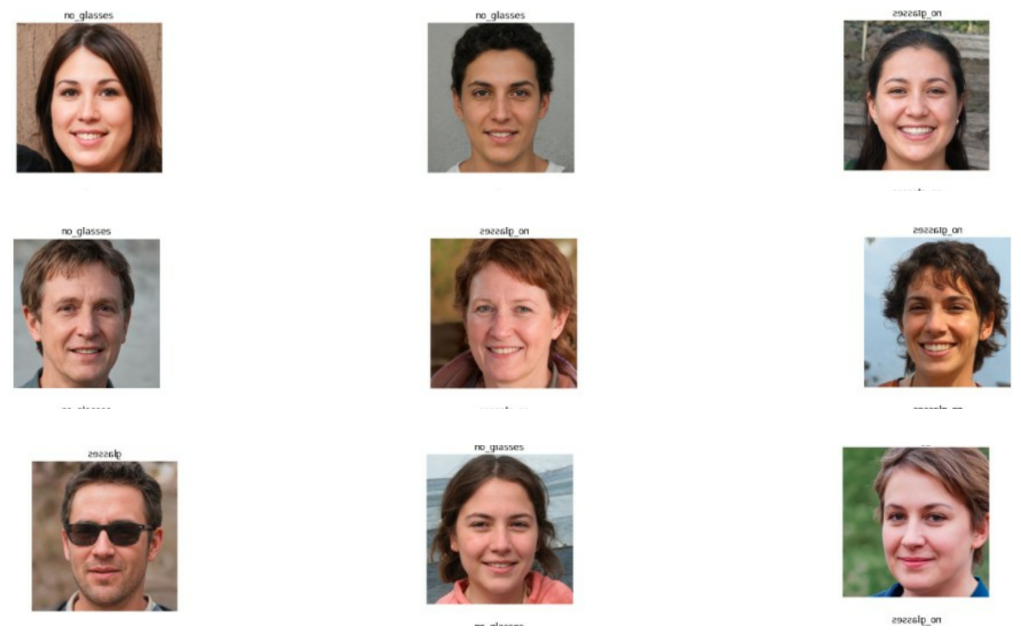

In [7]:
from keras.layers import RandomFlip 
from keras.models import Sequential

data_augmentation_pipeline = Sequential([
    RandomFlip("horizontal"),
])

plot_images(train_dataset, data_augmentation_pipeline)

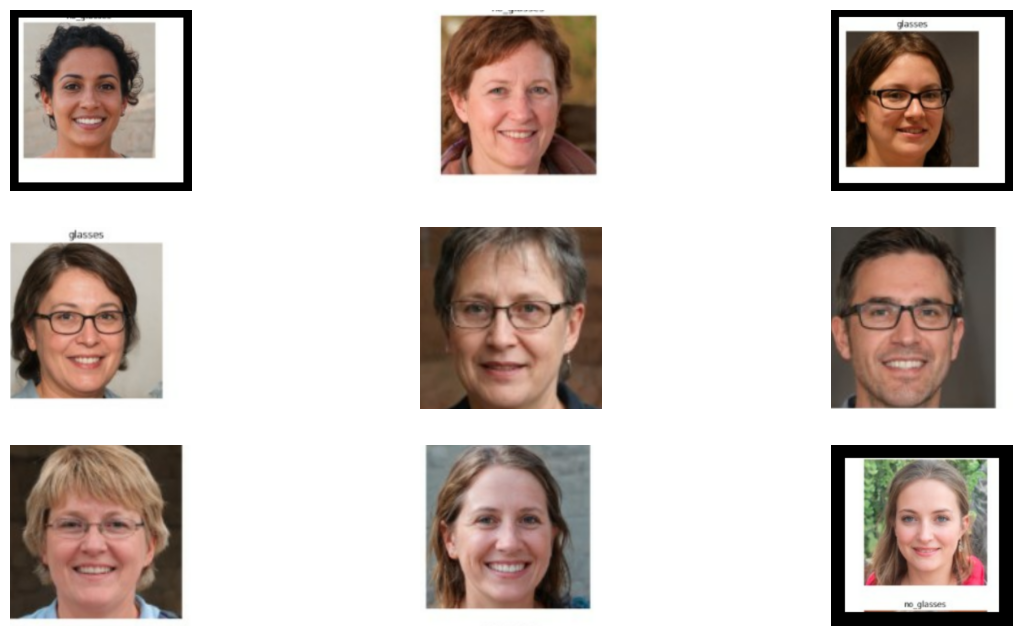

In [8]:
from keras.layers import RandomZoom 
from keras.models import Sequential

data_augmentation_pipeline = Sequential([
    RandomZoom(0.3, fill_mode="constant", fill_value=0),
])

plot_images(train_dataset, data_augmentation_pipeline)

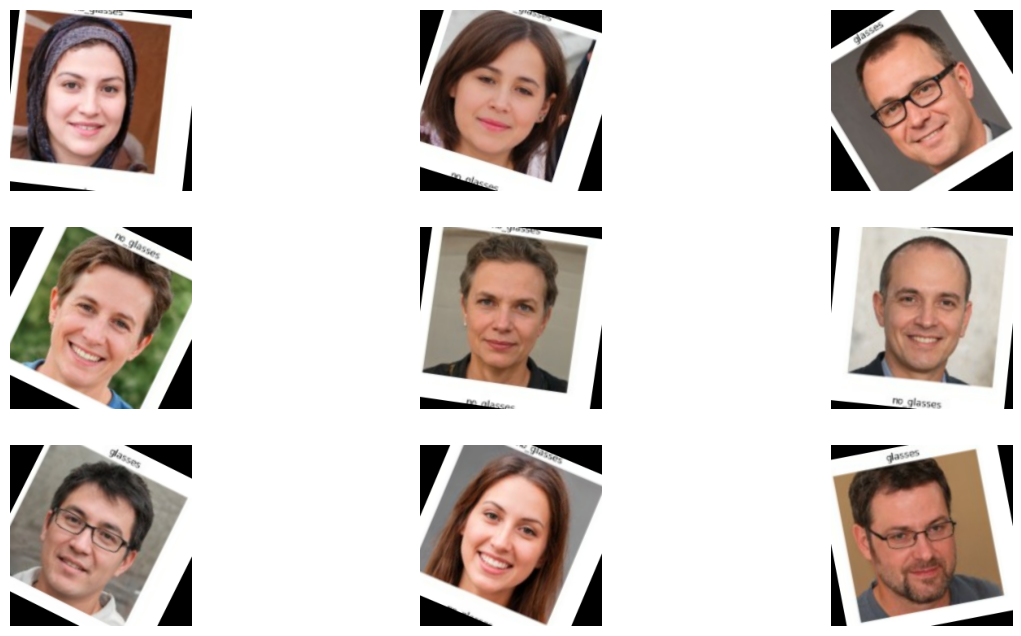

In [9]:
from keras.layers import RandomRotation
from keras.models import Sequential

data_augmentation_pipeline = Sequential([
    RandomRotation(0.1, fill_mode="constant", fill_value=0),
])

plot_images(train_dataset, data_augmentation_pipeline)

## Crear Modelo

In [10]:
from keras.applications import VGG16

base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

base_model.summary()

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno -3] Temporary failure in name resolution

In [ ]:
base_model.trainable = True

num_layers_fine_tune = 5
num_layers = len(base_model.layers)

for layer in base_model.layers[:num_layers - num_layers_fine_tune]:
    print(f"Layer {layer.name} will be frozen")
    layer.trainable = False

In [ ]:
from keras.models import Model
from keras.layers import Dense, Flatten, Input, RandomFlip, RandomZoom
from keras.applications.vgg16 import preprocess_input

input_layer = Input(shape=(224,224,3))

x = RandomFlip("horizonal")(input_layer)
x = RandomZoom(0.3)(x)
x = RandomRotation(0.1, fill_mode="constant", fill_value=0)(x)
x = preprocess_input(x)
x = base_model(x)
x = Flatten()(x)
x = Dense(units=1024, activation="relu")(x)
x = Dense(units=512, activation="relu")(x)
output = Dense(units=1, activation="sigmoid")(x)

model = Model(input_layer, output)

model.summary()

In [ ]:
from keras.optimizers import Adam

adam = Adam(learning_rate=0.0001)

model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=5)
checkpoint = ModelCheckpoint("./best_model.keras", monitor="val_loss", save_best_only=True)

In [ ]:
history = model.fit(train_dataset, validation_data= val_dataset, epochs=50, callbacks=[early_stop, checkpoint]) 

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss)
plt.plot(val_loss)

In [ ]:
import keras.utils as utils
from keras.models import load_model

model = load_model("./best_model.keras")

In [ ]:
test_image = utils.get_file("test3.jpg", "https://media.gq.com/photos/5ad8efd702cd085aa22a4f96/16:9/w_2560%2Cc_limit/2018-04_GQ_GoldbloomGlasses_lede.jpg")

In [ ]:
image = utils.load_img(test_image)
image = utils.img_to_array(image)

plt.imshow(image.astype(np.uint8))

In [ ]:
import cv2

image = cv2.resize(image, (224, 224))
image = np.expand_dims(image, axis=0)

In [ ]:
y_pred = model.predict(image)


In [ ]:
print(y_pred[0])

output = np.round(y_pred[0])
output = np.uint8(output)
print(output)

In [ ]:
label = train_dataset.class_names[output[0]]
print(label)